# Analítica de datos - ejemplo de clase - Regresion tf y keras

## Lectura base de datos y partición conjunto de entrenamiento y conjunto de evaluación

Nota: conjunto de evaluación no se utiliza en NINGUNA etapa de entrenamiento 

In [1]:
#Paso 1: Lectura
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from funciones_housing import dummy_transformer, pre_exploratorio, save_fig

from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline

%matplotlib inline
csv_path = 'datos/housing.csv'
Xdata = pd.read_csv(csv_path)

In [2]:
#Paso 2: Particion entrenamiento y validacion
# Tamaño Xtrain 70%, Tamaño Xtest 30%
Xtrain, Xtest = train_test_split(Xdata,test_size=0.3)
Xtrain,Xvalid = train_test_split(Xtrain,test_size=0.3)
col_sal = "median_house_value"
ytrain = Xtrain[col_sal]
ytest = Xtest[col_sal]
yvalid = Xvalid[col_sal]
Xtrain.drop(columns=col_sal,inplace=True)
Xtest.drop(columns=col_sal,inplace=True)
Xvalid.drop(columns=col_sal,inplace=True)

## Análisis exploratorio incial

Incluye: reducción de dimensión con PCA y t-SNE y ranking de relvancia por pca. Se puede complementar con diagramas de caja, de pastel, matrices de correlación, probabilidades condicionales, y agrupamiento (según la aplicación).

In [3]:
#%% Paso 2 : Analisis exploratorio
#preproceso entrada  y salida para analisis exploratorio
imp_out = SimpleImputer(strategy="most_frequent") 
ytrain = imp_out.fit_transform(pd.DataFrame(ytrain))
yvalid = imp_out.transform(pd.DataFrame(yvalid))
ytest = imp_out.transform(pd.DataFrame(ytest))

preproceso = dummy_transformer()
nor = StandardScaler()

Xtrain = preproceso.fit_transform(Xtrain)
Xvalid = preproceso.transform(Xvalid)


Xtrain = nor.fit_transform(Xtrain)
Xvalid = nor.transform(Xvalid)


Xtest = preproceso.transform(Xtest)
Xtest = nor.transform(Xtest)
#img_path = 'resultados/'
#pre_exploratorio(Xtrain,ytrain,img_path,col_sal)

# Entrenar modelo ANN según aplicación (clasificación, regresión, agrupamiento)


In [8]:
#Paso 3 : entrenar ann
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

#reiniciar sesion keras
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

#definir arquitectura secuencial
model = keras.models.Sequential([
    keras.layers.Dense(200, input_shape=(9,),
                       activation="relu"),
    keras.layers.Dense(50, activation="tanh"),
    keras.layers.Dense(1)
])

model.summary()

2.1.0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               2000      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 12,101
Trainable params: 12,101
Non-trainable params: 0
_________________________________________________________________


In [9]:
#compilar modelo
model.compile(loss=keras.losses.mse,
              optimizer="sgd",
              metrics=[keras.losses.mae])

In [10]:
#entrenar
history = model.fit(Xtrain, ytrain, epochs=30,batch_size=30,
                    validation_data=(Xvalid, yvalid))



Train on 10113 samples, validate on 4335 samples
Epoch 1/30
10113/10113 [==============================] - 1s 126us/sample - loss: 14080257887.2564 - mean_absolute_error: 93612.8438 - val_loss: 18022923872.9670 - val_mean_absolute_error: 95346.7812
Epoch 2/30
10113/10113 [==============================] - 1s 77us/sample - loss: 13719589771.2521 - mean_absolute_error: 92566.1328 - val_loss: 75208321086.8337 - val_mean_absolute_error: 253511.4844
Epoch 3/30
10113/10113 [==============================] - 1s 74us/sample - loss: 13969849782.3364 - mean_absolute_error: 93219.0703 - val_loss: 71010879210.6814 - val_mean_absolute_error: 245971.2812
Epoch 4/30
10113/10113 [==============================] - 1s 72us/sample - loss: 14005570765.8531 - mean_absolute_error: 93135.4688 - val_loss: 14153931355.0616 - val_mean_absolute_error: 87680.1172
Epoch 5/30
10113/10113 [==============================] - 1s 79us/sample - loss: 13748618901.1245 - mean_absolute_error: 92530.3594 - val_loss: 15208171

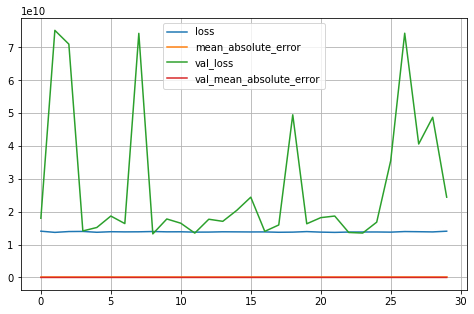

In [11]:
#graficar rendimiento entrenamiento
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
#save_fig("keras_learning_curves_plot")
plt.show()




# Calcular rendimiento en cojunto de test

mae(test)=112782.90
Guardando... mae_testing_set


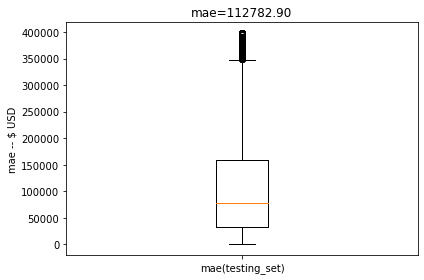

In [13]:
#%% Paso 5: evaluar sobre Xtest

img_path = 'resultados/'
ytest_e = model.predict(Xtest)
vmae = mean_absolute_error(np.array(ytest).reshape(1,-1),np.array(ytest_e).reshape(1,-1),multioutput='raw_values')
plt.boxplot(vmae)
print('mae(test)=%.2f' % mean_absolute_error(ytest,ytest_e))
plt.xticks([1],labels=['mae(testing_set)'])
plt.ylabel('mae -- $ USD')
plt.title('mae=%.2f'% mean_absolute_error(ytest,ytest_e))
save_fig(img_path,"mae_testing_set")
plt.show()

In [78]:
model.evaluate(Xtest,ytest)

6192/6192 [==============================] - 0s 20us/sample - loss: 22204785428.5065 - mean_absolute_error: 127358.9141


[22204785428.50646, 127358.914]

# Entrenamiento con API Funcional

In [14]:
input_ = keras.layers.Input(shape=Xtrain.shape[1:])
hidden1 = keras.layers.Dense(30,activation='tanh')(input_)
hidden2 = keras.layers.Dense(10,activation='tanh')(hidden1)
concat = keras.layers.Concatenate()([input_,hidden2])
output = keras.layers.Dense(1)(concat)
model_fun = keras.Model(inputs=[input_],outputs=[output])

In [45]:
hidden1 = keras.layers.Dense(30,activation='tanh')(input_)
hidden2 = keras.layers.Dense(10,activation='tanh')(hidden1)
concat = keras.layers.Concatenate()([input_,hidden2])
output_A = keras.layers.Dense(1)(concat)
output_B = keras.layers.Dense(1,activation="sigmoid")(concat)
model_2out = keras.Model(inputs=[input_],outputs=[output_A,output_B])

In [46]:
model_2out.compile(loss=[keras.losses.mse,keras.losses.binary_crossentropy],
              optimizer="sgd", loss_weights = [0.7,0.3],
              metrics=[keras.losses.mae,"accuracy"])

In [47]:
ytrainB= ytrain>ytrain.mean()
yvalidB= yvalid>yvalid.mean()


In [48]:
history = model_2out.fit(Xtrain,[ytrain,ytrainB],
                         epochs=30,
                         validation_data=([Xvalid],[yvalid,yvalidB]))

Train on 10113 samples, validate on 4335 samples
Epoch 1/30
10113/10113 [==============================] - 2s 212us/sample - loss: 7050725697.6897 - dense_20_loss: 10051673088.0000 - dense_21_loss: 0.9508 - dense_20_mean_absolute_error: 72459.0859 - dense_20_accuracy: 0.0000e+00 - dense_21_mean_absolute_error: 0.5330 - dense_21_accuracy: 0.4610 - val_loss: 4910149900.1947 - val_dense_20_loss: 6998653440.0000 - val_dense_21_loss: 0.8242 - val_dense_20_mean_absolute_error: 59970.8320 - val_dense_20_accuracy: 0.0000e+00 - val_dense_21_mean_absolute_error: 0.5049 - val_dense_21_accuracy: 0.4960
Epoch 2/30
10113/10113 [==============================] - 1s 96us/sample - loss: 4402357289.7174 - dense_20_loss: 6292424704.0000 - dense_21_loss: 0.7405 - dense_20_mean_absolute_error: 57712.4375 - dense_20_accuracy: 0.0000e+00 - dense_21_mean_absolute_error: 0.4857 - dense_21_accuracy: 0.5177 - val_loss: 3931292369.1700 - val_dense_20_loss: 5606557696.0000 - val_dense_21_loss: 0.6875 - val_dense_2

Epoch 16/30
10113/10113 [==============================] - 1s 124us/sample - loss: 3379953355.1698 - dense_20_loss: 4842342912.0000 - dense_21_loss: 0.4503 - dense_20_mean_absolute_error: 51051.0781 - dense_20_accuracy: 0.0000e+00 - dense_21_mean_absolute_error: 0.3234 - dense_21_accuracy: 0.8037 - val_loss: 3461719758.4535 - val_dense_20_loss: 4940892160.0000 - val_dense_21_loss: 0.4523 - val_dense_20_mean_absolute_error: 51301.7422 - val_dense_20_accuracy: 0.0000e+00 - val_dense_21_mean_absolute_error: 0.3221 - val_dense_21_accuracy: 0.8042
Epoch 17/30
10113/10113 [==============================] - 2s 150us/sample - loss: 3380003635.5708 - dense_20_loss: 4816448000.0000 - dense_21_loss: 0.4470 - dense_20_mean_absolute_error: 51142.7422 - dense_20_accuracy: 0.0000e+00 - dense_21_mean_absolute_error: 0.3203 - dense_21_accuracy: 0.8045 - val_loss: 3379008117.3998 - val_dense_20_loss: 4822241792.0000 - val_dense_21_loss: 0.4491 - val_dense_20_mean_absolute_error: 51558.6602 - val_dense_2

In [63]:
ytestA,ytestB = model_2out.predict(Xtest[2].reshape(1,-1))

In [64]:
ytestB

array([[0.7134224]], dtype=float32)

In [65]:
ytestA

array([[264667.97]], dtype=float32)